In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re

from collections import defaultdict

First download the secCellFie repo from https://github.com/LewisLabUCSD/secCellFie/tree/master, and add the path below

In [2]:
# Path to the folder containing the inputs in the secCellFie repository
folder = '../../secCellFie-master/CellFie/input/'

# Metabolic reconstruction

In [3]:
from cobra.io import load_matlab_model

In [4]:
model = scipy.io.loadmat(folder + '/MT_recon_2_2_entrez_sec.mat')['model']

In [5]:
len(model[0][0])

28

In [6]:
_rxn_names = model[0][0][1]
_met_names = model[0][0][2]
_S = model[0][0][3]
_c = model[0][0][5]
_lb = model[0][0][8]
_ub = model[0][0][9]
_gene_names = model[0][0][12]
_gprs = model[0][0][14]

In [7]:
_rxn_ids = []
for i in range(_rxn_names.shape[0]):
    _rxn_ids.append(_rxn_names[i][0][0])

In [8]:
_gpr_records = []
for _rxn, _gpr in zip(_rxn_ids, _gprs):
    if _gpr[0].shape[0] == 0:
        continue
    else:
        _gpr_records.append((_rxn, _gpr[0][0].replace('HGNC:HGNC:', 'HGNC:')))

# Generate task information

In [9]:
mat = scipy.io.loadmat(folder + '/taskStructure_met_sec.mat')

In [10]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Dec 22 12:36:34 2022',
 '__version__': '1.0',
 '__globals__': [],
 'taskInfos': array([[array(['1'], dtype='<U1'),
         array(['Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)'],
               dtype='<U72')                                                                ,
         array(['ENERGY METABOLISM'], dtype='<U17'),
         array(['OXYDATIVE PHOSPHORYLATION'], dtype='<U25')],
        [array(['2'], dtype='<U1'),
         array(['Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)'],
               dtype='<U78')                                                                      ,
         array(['ENERGY METABOLISM'], dtype='<U17'),
         array(['OXYDATIVE PHOSPHORYLATION'], dtype='<U25')],
        [array(['3'], dtype='<U1'),
         array(['Krebs cycle - oxidative decarboxylation of pyruvate'],
               dtype='<U51')                         

In [11]:
mat['taskInfos'][0]

array([array(['1'], dtype='<U1'),
       array(['Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)'],
             dtype='<U72')                                                                ,
       array(['ENERGY METABOLISM'], dtype='<U17'),
       array(['OXYDATIVE PHOSPHORYLATION'], dtype='<U25')], dtype=object)

In [12]:
records = []

for i, task in enumerate(mat['taskInfos']):
    name = task[1][0]
    system = task[2][0]
    subsystem = task[3][0]
    
    records.append((name, system, subsystem))

In [13]:
records

[('Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)',
  'ENERGY METABOLISM',
  'OXYDATIVE PHOSPHORYLATION'),
 ('Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)',
  'ENERGY METABOLISM',
  'OXYDATIVE PHOSPHORYLATION'),
 ('Krebs cycle - oxidative decarboxylation of pyruvate',
  'ENERGY METABOLISM',
  'KREBS CYCLE'),
 ('Krebs cycle - NADH generation', 'ENERGY METABOLISM', 'KREBS CYCLE'),
 ('ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
  'ENERGY METABOLISM',
  'ATP GENERATION'),
 ('ATP generation from glucose (hypoxic conditions) - glycolysis',
  'ENERGY METABOLISM',
  'ATP GENERATION'),
 ('Reactive oxygen species detoxification (H2O2 to H2O)',
  'ENERGY METABOLISM',
  'OXIDATIVE PHOSPHORYLATION & ROS DETOXIFICATION'),
 ('Presence of the thioredoxin system through the thioredoxin reductase activity',
  'ENERGY METABOLISM',
  'REDOX METABOLISM'),
 ('Inosine monophosphate synthesis (IMP)',
  'NUCLEOTIDE

In [14]:
task_df = pd.DataFrame.from_records(records, columns=['Task', 'System', 'Subsystem']).set_index('Task')

In [15]:
task_df

,System,Subsystem
Task,,
Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I),ENERGY METABOLISM,OXYDATIVE PHOSPHORYLATION
Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II),ENERGY METABOLISM,OXYDATIVE PHOSPHORYLATION
Krebs cycle - oxidative decarboxylation of pyruvate,ENERGY METABOLISM,KREBS CYCLE
Krebs cycle - NADH generation,ENERGY METABOLISM,KREBS CYCLE
ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,ENERGY METABOLISM,ATP GENERATION
...,...,...
Trafficking to endosomes (Clathrin Vesicles),Vesicle trafficking,Endosomal trafficking
COPI mediated retrograde transport,Vesicle trafficking,Golgi to ER trafficking (COPI)
COPII-LMAN1 mediated anterograde transport,Vesicle trafficking,ER to Golgi trafficking (COPII)


# Task by reactions

In [16]:
rxns = scipy.io.loadmat(folder + '/essentialRxns/essentialRxnsbyTask_MT_recon_2_2_entrez_met_sec.mat')

In [17]:
records = []
rxn_set = set()
for i, task in enumerate(rxns['essentialRxns'].T):
    name = task_df.index[i]
    
    for reaction in task[0]:
        rxn = reaction[0][0]
        records.append((name, rxn))
        rxn_set.add(rxn)

In [18]:
task_rxn_df = pd.DataFrame.from_records(records, columns=['Task', 'Reaction'])

In [19]:
task_by_rxn = pd.crosstab(task_rxn_df['Task'], task_rxn_df['Reaction'])
task_by_rxn[task_by_rxn > 0] = 1

In [20]:
task_by_rxn.shape

(213, 955)

In [21]:
len(rxn_set)

955

In [22]:
task_by_rxn.sum(axis=1).sort_values(ascending=False)

Task
Lysine degradation                                                          111
Tryptophan degradation                                                      103
Isoleucine degradation                                                      101
Sphingomyelin synthesis                                                     100
Phosphatidyl-choline synthesis                                               99
                                                                           ... 
Synthesis of phosphatidylinositol from inositol                               1
Synthesis of fructose-6-phosphate from erythrose-4-phosphate (HMP shunt)      1
Conversion of carnosine to beta-alanine                                       1
Conversion of aspartate to beta-alanine                                       1
Conversion of histidine to histamine                                          1
Length: 213, dtype: int64

<Axes: >

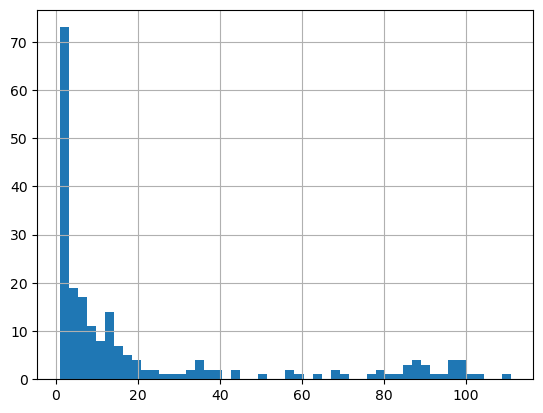

In [23]:
task_by_rxn.sum(axis=1).hist(bins=50)

# GPRs

In [24]:
rxn_list = pd.DataFrame.from_records(_gpr_records, columns=['Reaction', 'GPR'])

In [25]:
rxn_list.head()

,Reaction,GPR
0,13DAMPPOX,HGNC:549 or HGNC:550 or HGNC:80
1,24_25VITD2Hm,HGNC:2602
2,24_25VITD3Hm,HGNC:2602
3,25VITD2Hm,HGNC:2606
4,25VITD3Hm,HGNC:2606


In [26]:
met_df = pd.read_excel('idmap.xlsx') # Gene ID mapper from entrez to HGNC

In [27]:
met_df

,query,entrezgene,name,symbol,alias,taxid,HGNC
0,53947,53947,"alpha 1,4-galactosyltransferase (P blood group)",A4GALT,"A14GALT, A4GALT1, Gb3S, P(k), P1",9606,HGNC:18149
1,51146,51146,"alpha-1,4-N-acetylglucosaminyltransferase",A4GNT,alpha4GnT,9606,HGNC:17968
2,65985,65985,acetoacetyl-CoA synthetase,AACS,"ACSF1, SUR-5",9606,HGNC:21298
3,13,13,arylacetamide deacetylase,AADAC,"CES5A1, DAC",9606,HGNC:17
4,51166,51166,aminoadipate aminotransferase,AADAT,"KAT2, KATII, KYAT2",9606,HGNC:17929
...,...,...,...,...,...,...,...
1668,55350,55350,"vanin 3, pseudogene",VNN3P,"HSA238982, VNN3",9606,HGNC:16431
1669,7498,7498,xanthine dehydrogenase,XDH,"XAN1, XO, XOR",9606,HGNC:12805
1670,9942,9942,xylulokinase,XYLB,NaN,9606,HGNC:12839
1671,64131,64131,xylosyltransferase 1,XYLT1,"DBQD2, PXYLT1, XT-I, XT1, XTI",9606,HGNC:15516


In [28]:
genes = scipy.io.loadmat(folder + '/parsedGPR/parsedGPR_MT_recon_2_2_entrez_sec.mat')

In [29]:
genes['parsedGPR']

array([[array([[array([[array(['314'], dtype='<U3')]], dtype=object),
                array([[array(['8639'], dtype='<U4')]], dtype=object),
                array([[array(['26'], dtype='<U2')]], dtype=object)]],
              dtype=object)                                           ],
       [array([[array([], dtype='<U1')]], dtype=object)],
       [array([[array([], dtype='<U1')]], dtype=object)],
       ...,
       [array([[array([[array(['143471'], dtype='<U6')],
                       [array(['5682'], dtype='<U4')],
                       [array(['5683'], dtype='<U4')],
                       [array(['5684'], dtype='<U4')],
                       [array(['5685'], dtype='<U4')],
                       [array(['5686'], dtype='<U4')],
                       [array(['5688'], dtype='<U4')]], dtype=object)]],
              dtype=object)                                             ],
       [array([[array([[array(['122706'], dtype='<U6')],
                       [array(['5689'], dtype='<U4

In [30]:
len(rxn_list['Reaction']), len(genes['parsedGPR'])

(4870, 7929)

In [31]:
genes['parsedGPR'][-4][0][0][0]

array([], dtype='<U1')

In [32]:
gene_names = set()
for idx, row in rxn_list.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR']
    if isinstance(gpr, str):
        elements = re.findall(r'\b[\w:]+\b', gpr)
        _genes = [e for e in elements if e not in ('and', 'or', 'AND', 'OR')]
        for g in _genes:
            if 'HGNC:' not in g:
                gene_names.add(str(g))

In [33]:
len(gene_names)

223

### Grab new genes from secCellFie

In [34]:
import mygene

In [35]:
mg = mygene.MyGeneInfo()

In [36]:
geneid_df = mg.getgenes(gene_names, fields='entrezgene,symbol,name,alias,taxid,HGNC', as_dataframe=True)

In [37]:
geneid_df = geneid_df.reset_index().drop(columns=['_id', '_version'])

In [38]:
geneid_df[geneid_df['entrezgene'] == '5689']

,query,HGNC,alias,entrezgene,name,symbol,taxid
130,5689,9537,"[HC5, NEDMHAL, PMSB1, PSC5]",5689,proteasome 20S subunit beta 1,PSMB1,9606


In [39]:
_df = geneid_df.copy()
_df['HGNC'] = ['HGNC:' + g for g in _df['HGNC']]
_df['alias'] = [', '.join(a) if isinstance(a, list) else a for a in _df['alias']]

In [40]:
met_df.shape, _df.shape

((1673, 7), (223, 7))

In [41]:
sec_df = pd.concat([met_df,_df[met_df.columns]])

### Mappers

In [42]:
gene_id = sec_df[['entrezgene', 'symbol']].set_index('entrezgene').to_dict()['symbol']
gene_id = {str(k) : v for k, v in gene_id.items()}

In [43]:
entrez2hgnc = sec_df[['entrezgene', 'HGNC']].set_index('entrezgene').to_dict()['HGNC']
entrez2hgnc = {str(k) : v for k, v in entrez2hgnc.items()}

In [44]:
hgnc2entrez = {v : k for k,v in entrez2hgnc.items()}

In [45]:
hgnc_id = sec_df[['symbol', 'HGNC']].set_index('HGNC').to_dict()['symbol']

In [46]:
def find_genes_gpr(gpr_rule):
    elements = re.findall(r'\b[^\s(),]+\b', gpr_rule)
    return [e for e in elements if e.lower() not in ('and', 'or')]

In [47]:
def replace_gene_ids_in_gpr(gpr_rule, gene_id_mapping):
    # Use regular expressions to find gene IDs in the GPR rule
    gene_ids = find_genes_gpr(gpr_rule)

    # Replace gene IDs with their mapped values
    updated_gpr_rule = gpr_rule
    for gene_id in gene_ids:
        if gene_id in gene_id_mapping:
            # Check if the gene ID is surrounded by parentheses
            if f"({gene_id})" in updated_gpr_rule:
                updated_gpr_rule = updated_gpr_rule.replace(f"({gene_id})", gene_id_mapping[gene_id])
            else:
                updated_gpr_rule = updated_gpr_rule.replace(f"{gene_id}", gene_id_mapping[gene_id])

    return updated_gpr_rule

In [48]:
def clean_gene_names(gpr_rule):
    # Regular expression pattern to match spaces between numbers and parentheses
    pattern = r'(\()\s*(\d+)\s*(\))'

    # Replace the matched pattern with parentheses directly around the numbers
    cleaned_rule = re.sub(pattern, r'(\2)', gpr_rule)

    return cleaned_rule

In [49]:
for idx, row in rxn_list.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR']
    if isinstance(gpr, str):
        if ('HGNC:' not in gpr):
            gpr_new = clean_gene_names(gpr)
            old_ids = find_genes_gpr(gpr)
            new_ids = find_genes_gpr(gpr_new)
            
            assert(all([x1 == x2 for x1, x2 in zip(sorted(old_ids), sorted(new_ids))]))

In [50]:
gpr

'( 5689 ) and ( 5690 ) and ( 5691 ) and ( 5692 ) and ( 5693 ) and ( 5694 ) and ( 5695 ) and ( 5696 ) and ( 5698 ) and ( 5699 ) and ( 122706 )'

In [51]:
gpr_new

'(5689) and (5690) and (5691) and (5692) and (5693) and (5694) and (5695) and (5696) and (5698) and (5699) and (122706)'

In [52]:
all([x1 == x2 for x1, x2 in zip(sorted(old_ids), sorted(new_ids))])

True

In [53]:
# Convert entrez to HGNC
records = []
for idx, row in rxn_list.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR']
    if isinstance(gpr, str):
        gpr = clean_gene_names(gpr)
        gpr = replace_gene_ids_in_gpr(gpr, entrez2hgnc)
        records.append((rxn_name, gpr))

rxn_list_updated = pd.DataFrame.from_records(records, columns=rxn_list.columns)
rxn_list_updated['GPR-symbol'] = rxn_list_updated['GPR'].apply(lambda x: replace_gene_ids_in_gpr(x, hgnc_id) if isinstance(x, str) else np.nan)
rxn_list_updated['GPR-symbol'] = rxn_list_updated['GPR-symbol'].replace(np.nan, '')

In [54]:
rxn_list_updated.shape

(4870, 3)

In [55]:
rxn_records = []
for idx, row in rxn_list_updated.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR-symbol']
    if isinstance(gpr, str):
        elements = re.findall(r'\b[\w:]+\b', gpr)
        _genes = [e for e in elements if e not in ('and', 'or', 'AND', 'OR')]
        for g in _genes:
            rxn_records.append((rxn_name, g))

In [56]:
rxn_gene_df = pd.DataFrame.from_records(rxn_records, columns=['Reaction', 'Gene'])

In [57]:
rxn_gene_df.head()

,Reaction,Gene
0,13DAMPPOX,AOC2
1,13DAMPPOX,AOC3
2,13DAMPPOX,AOC1
3,24_25VITD2Hm,CYP24A1
4,24_25VITD3Hm,CYP24A1


In [58]:
metabolic_genes = sorted(set(rxn_gene_df.Gene.unique()))

In [59]:
len(metabolic_genes)

1855

In [60]:
rxn_by_gene = pd.crosstab(rxn_gene_df['Reaction'], rxn_gene_df['Gene'])
rxn_by_gene[rxn_by_gene > 0] = 1
rxn_by_gene=rxn_by_gene.reindex(rxn_list['Reaction'].values, fill_value=0.0)

In [61]:
rxn_by_gene

Gene,A4GALT,A4GNT,AACS,AADAC,AADAT,AANAT,AASS,ABAT,ABCA1,ABCA3,...,UST,UXS1,VCP,VNN1,VNN2,VNN3P,XDH,XYLB,XYLT1,XYLT2
Reaction,,,,,,,,,,,,,,,,,,,,,
13DAMPPOX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24_25VITD2Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24_25VITD3Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25VITD2Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25VITD3Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
co_TRANSLOC_6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BiP_release,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SP_degradation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
task_by_rxn

Reaction,10FTHFtm,1PPDCRp,2OXOADOXm,2OXOADPTm,34HPLFM,34HPPOR,3DPHBH1,3DSPHR,3HAO,3HLYTCL,...,r2472,r2473,r2516,r2518,r2537,r2539,retro_TRANSLOC_1,retro_TRANSLOC_2,sink_citr(c),sink_pre_prot(r)
Task,,,,,,,,,,,,,,,,,,,,,
(R)-3-Hydroxybutanoate synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3'-Phospho-5'-adenylyl sulfate synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AMP salvage from adenine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATP generation from glucose (hypoxic conditions) - glycolysis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cis-vaccenic acid synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamma-Linolenate degradation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamma-Linolenate synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
total_met_rxn = rxn_list_updated.loc[rxn_list_updated['Reaction'].isin(rxn_set)]['Reaction'].tolist()

In [64]:
len(total_met_rxn)

767

In [65]:
task_by_rxn = task_by_rxn[total_met_rxn]

In [66]:
task_by_rxn.shape

(213, 767)

In [67]:
rxn_by_gene = rxn_by_gene.loc[total_met_rxn,:]

In [68]:
rxn_by_gene.shape

(767, 1855)

In [69]:
task_by_gene = np.matmul(task_by_rxn, rxn_by_gene)
task_by_gene[task_by_gene > 0] = 1

In [70]:
task_by_gene.columns[task_by_gene.columns.str.contains('HGNC:')]

Index([], dtype='object', name='Gene')

In [71]:
task_by_gene.shape

(213, 1855)

In [72]:
final_genes = task_by_gene.loc[:,task_by_gene.sum()>0].columns.tolist()

In [73]:
final_tasks = task_by_gene.loc[task_by_gene.sum(axis=1)>0].index.tolist()

In [74]:
final_rxns = rxn_by_gene[final_genes][rxn_by_gene[final_genes].sum(axis=1)>0].index.tolist()

In [75]:
len(final_rxns)

767

In [76]:
task_by_rxn = task_by_rxn.loc[final_tasks, final_rxns]
task_by_rxn.shape

(210, 767)

In [77]:
task_by_gene = task_by_gene.loc[final_tasks, final_genes]
task_by_gene.shape

(210, 884)

In [78]:
rxn_by_gene = rxn_by_gene.loc[final_rxns, final_genes]
rxn_by_gene.shape

(767, 884)

In [79]:
rxn_list_updated = rxn_list_updated.loc[rxn_list_updated['Reaction'].isin(final_rxns)].reset_index(drop=True)

In [80]:
task_df = task_df.loc[final_tasks,:]

# Exports

In [81]:
task_df.to_csv('./homo_sapiens/Task-Info.csv')

In [82]:
task_by_rxn.to_csv('./homo_sapiens/Task_by_Rxn.csv')

In [83]:
rxn_by_gene.to_csv('./homo_sapiens/Rxn_by_Gene.csv')

In [84]:
task_by_gene.to_csv('./homo_sapiens/Task_by_Gene.csv')

In [85]:
rxn_list_updated.to_json('./homo_sapiens/Rxn-Info-Recon2-2.json')

In [86]:
import json
with open('./homo_sapiens/Recon_metabolic_genes.json', 'w') as fp:
    json.dump(metabolic_genes, fp)

In [87]:
with open('./homo_sapiens/Human1_metabolic_genes.json') as fp:
    human1_genes = json.load(fp)

In [88]:
all_met_genes = sorted(set(metabolic_genes + human1_genes))

In [89]:
with open('./homo_sapiens/All_metabolic_genes.json', 'w') as fp:
    json.dump(all_met_genes, fp)